In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import os
import subprocess as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(4)

from models import EarlyStopping, GRU
from utilities import get_NSE, MSE, get_colors, print_notes, inverse_transform_sp
from preprocess import load_data, SampleData, init_one_feat

np.random.seed(4)

In [2]:
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

if torch.cuda.is_available():
    device = torch.device("cuda")
if get_gpu_memory()[0] < 1500 :
    device = torch.device("cpu")
print(device)

# Get colors
colors = get_colors()
colors

cuda


array(['deeppink', 'darkviolet', 'darkgray', 'darkblue', 'darkkhaki',
       'deepskyblue', 'darkslategray', 'darkgreen', 'darkslategrey',
       'darkseagreen', 'darkred', 'darkmagenta', 'darksalmon',
       'darkorchid', 'darkorange', 'darkgoldenrod', 'darkturquoise',
       'darkolivegreen', 'darkcyan', 'darkgrey', 'darkslateblue'],
      dtype='<U14')

In [3]:
# output_vars = ['SW_ENDmm']
# run_task = 'Train_CMB_inf_SCIF_SW'
output_vars = ['SNOmm']
run_task = 'Train_CMB_inf_SCIF_SNO'
# run_task = 'Train_CMB_inf_SCIF_fullStride_SNO'
# output_vars = ['Q_pred_mm']
# run_task = 'Train_CMB_inf_SCIF_SF'
if output_vars[0] == "SW_ENDmm":
    state_input = 'SW_INITmm'
else:
    state_input = output_vars[0]

sim_type = 'full_wsl'
rversion = 'hs32'
#----------------paths-------------------
res_dir = '../results/head_water_SWAT_1000_years/'
exp_dir = res_dir + '{}/rversion_{}/'.format(run_task, rversion)

#--------------------------------------------- load input data -----------------------------
new_data_dir = '../data/1000_year_simulation/'
if sim_type =='full_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years.csv'
elif sim_type =='nosnow_nofrozen_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow_no_frozen.csv'
elif sim_type =='nosnow_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow.csv'
else:
    raise FileNotFoundError

In [4]:
run_iter = 5
max_iter = run_iter
n_steps = 366
hidden_size = 32
epochs = 500
learning_rate = 0.01
n_classes = len(output_vars)
batch_size = 64
input_size = 8
dropout = 0
nlayers=1
patience = 50

input_vars = ['Date', 'PRECIPmm', 'TMP_MXdgC', 'TMP_MNdgC', 'SOLARMJ/m2', 'WINDM/s', 'RHmd', state_input]
assert(len(input_vars) == input_size)

params = np.load(exp_dir + 'params_ss_{}.npy'.format(n_steps),allow_pickle=True).tolist()
print("The network hypermeters : ")
for k,v in params.items():
    if k != "notes":
        print(k,v)
    if k == "notes":
        print()
        print_notes(params['notes'][0])

The network hypermeters : 
learning_rate 0.01
epochs 500
batch_size 64
hidden_size 32
input_size 8
n_steps 366
dropout 0.0
n_classes 1
num_samples_train 0
shift_train 183
num_samples_valid 0
shift_valid 183
num_samples_test 0
shift_test 183
train_percentage 0.5
valid_percentage 0.1

Goal: Simulate the target variable using state input and 7 weather drivers including Date, PRECIPmm, TMP_MXdgC, TMP_MNdgC, SOLARMJ/m2, WINDM/s, RHmd 
Target variables: SW_ENDmm, SNOmm, Q_pred_mm
Data: 1000 years simulation data
Split data: First 50% of data as the training set, middle 10% of data as the validation set,  last 40% of data as the testing set
Settings:
- Training: Conditional mini-batch (CMB) algorithm
- Model: one layer GRU



In [5]:
df = pd.read_csv(path)
feat, label = load_data(df, output_vars, input_vars, input_size)

# First 50% of data as the training set, middle 10% of data as the validation set, last 40% of data as the testing set.
train_percentage = 0.5
valid_percentage = 0.1
test_percentage = 1 - (train_percentage + valid_percentage)

# Split data
T = feat.shape[0]
train_len = int(T*train_percentage)
valid_len = int(T*valid_percentage)
test_len = T - train_len - valid_len
print(train_len,valid_len,test_len)
train_x = feat[:train_len].copy()
train_y = label[:train_len].copy()
valid_x = feat[train_len:train_len+valid_len].copy()
valid_y = label[train_len:train_len+valid_len].copy()
test_x = feat[train_len+valid_len:].copy()
test_y = label[train_len+valid_len:].copy()

# Normalize data
scaler_x = StandardScaler()
scaler_x.fit(train_x) 
x_train = scaler_x.transform(train_x)
x_valid = scaler_x.transform(valid_x)
x_test = scaler_x.transform(test_x)
scaler_y = StandardScaler()
scaler_y.fit(train_y)
y_train = scaler_y.transform(train_y)
y_valid = scaler_y.transform(valid_y)
y_test = scaler_y.transform(test_y)

# Sample data
## Get indexes
train_idx = np.arange(len(y_train))
valid_idx = np.arange(len(y_valid))
test_idx = np.arange(len(y_test))
## Set stride
num_samples_train = 0
shift_train = int(n_steps/2)
num_samples_valid = 0
shift_valid = int(n_steps/2)
num_samples_test = 0
shift_test = int(n_steps/2)
## Get lists of indexes to sample data. 
train_idx_arr = SampleData(train_idx,n_steps,shift_train,num_samples_train)
num_train_samples = train_idx_arr.shape[0]
valid_idx_arr = SampleData(valid_idx,n_steps,shift_valid,num_samples_valid)
num_valid_samples = valid_idx_arr.shape[0]
test_idx_arr = SampleData(test_idx,n_steps,shift_test,num_samples_test)
num_test_samples = test_idx_arr.shape[0]
## Sample data
x_train_sp_ = x_train[train_idx_arr,:]
y_train_sp_ = y_train[train_idx_arr,:]
m_train_sp_ = y_train_sp_.copy()
m_train_sp_[:,:,:] = 1 # no masking
x_valid_sp_ = x_valid[valid_idx_arr,:]
y_valid_sp_ = y_valid[valid_idx_arr,:]
m_valid_sp_ = y_valid_sp_.copy()
m_valid_sp_[:,:,:] = 1 # no masking
x_test_sp_ = x_test[test_idx_arr,:]
y_test_sp_ = y_test[test_idx_arr,:]
m_test_sp_ = y_test_sp_.copy()
m_test_sp_[:,:,:] = 1 # no masking

# Only keep the initial value of the state feature in each segment for CMB training
x_train_sp_ = init_one_feat(x_train_sp_,-1)
x_valid_sp_ = init_one_feat(x_valid_sp_,-1)
x_test_sp_ = init_one_feat(x_test_sp_,-1)

# Send data to the device
x_train_sp = torch.from_numpy(x_train_sp_).type(torch.float32).to(device)
y_train_sp = torch.from_numpy(y_train_sp_).type(torch.float32).to(device)
m_train_sp = torch.from_numpy(m_train_sp_).type(torch.float32).to(device)

x_valid_sp = torch.from_numpy(x_valid_sp_).type(torch.float32).to(device)
y_valid_sp = torch.from_numpy(y_valid_sp_).type(torch.float32).to(device)
m_valid_sp = torch.from_numpy(m_valid_sp_).type(torch.float32).to(device)

x_test_sp = torch.from_numpy(x_test_sp_).type(torch.float32).to(device)
y_test_sp = torch.from_numpy(y_test_sp_).type(torch.float32).to(device)
m_test_sp = torch.from_numpy(m_test_sp_).type(torch.float32).to(device)

182622 36524 146098
182622
36524
146098


In [6]:
def SCIF_inference(model_trained, x_test_sp, scaler_y):
    '''
    SCIF use the initial predicted state values make predictions.
    '''
    x_test_sp = x_test_sp.clone().detach()
    pred = []
    hiddens_list = []
    with torch.no_grad():
        hidden_head = model_trained.init_hidden(1)
        pred_one,hiddens_one = model_trained(torch.unsqueeze(x_test_sp[0],0),hidden_head)
        pred_one = torch.squeeze(pred_one)
        hiddens_one = torch.squeeze(hiddens_one)
        val = pred_one[int(n_steps/2)-1]
        pred.append(pred_one.cpu().numpy())
        hiddens_list.append(hiddens_one.cpu().numpy())


        # We make predictions sequentially to apply SA-learning on testing phase.
        for i in range(1, len(x_test_sp)):
            # avoid to overwrite the original data for safety consideration. 
            x_temp = torch.clone(x_test_sp[i]).detach()
            # the last features is SW_Init. We can extend this code if we need to apply SA-leanring on multiple variables.
            # copy the a corresponding prediction as the intial value for the current sequence at the head of sequence.
            x_temp[:,-1] = val
            hidden_head = model_trained.init_hidden(1)
            pred_one,hiddens_one = model_trained(torch.unsqueeze(x_temp,0),hidden_head)

            pred_one = torch.squeeze(pred_one)
            hiddens_one = torch.squeeze(hiddens_one)
            val = pred_one[int(n_steps/2)-1]
            pred.append(pred_one.cpu().numpy())
            hiddens_list.append(hiddens_one.cpu().numpy())
            
    pred = np.squeeze(pred)
    pred_shape = pred.shape
    pred = pred.reshape(-1,n_classes)
    pred = scaler_y.inverse_transform(pred).reshape(pred_shape)
    hiddens_list = np.squeeze(hiddens_list)
    
    return pred, hiddens_list

In [7]:
tot_epoch = 0
tot_time = 0
for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # Load the best validation model
    path_save = exp_dir+"run_iter_{}_final_model.sav".format(run_iter)
    # # Load the final epoch model
    # path_save = exp_dir+"final_model.sav"
    checkpoint=torch.load(path_save)
    #output 7 in first module and 3 in second module
    epoch = checkpoint['epoch']
    training_time = checkpoint['train_time']
    tot_epoch += epoch
    tot_time += training_time
    print("Total epoch : {}".format(epoch))
    print("Total training time : {}".format(training_time))
    
print("{:.4f} second/epoch".format(tot_time / tot_epoch))

Iteration 0
Total epoch : 383
Total training time : 11.305654048919678
Iteration 1
Total epoch : 265
Total training time : 7.868773937225342
Iteration 2
Total epoch : 499
Total training time : 14.604501485824585
Iteration 3
Total epoch : 487
Total training time : 14.460545301437378
Iteration 4
Total epoch : 499
Total training time : 14.770793676376343
0.0295 second/epoch


In [8]:
def get_model(run_iter,path="run_iter_{}_best_model.sav"):
    # Load the best validation model
    path_save = exp_dir+path.format(run_iter)
    # # Load the final epoch model
    # path_save = exp_dir+"final_model.sav"
    checkpoint=torch.load(path_save)
    #output 7 in first module and 3 in second module
    model_trained=GRU(input_size, hidden_size, nlayers, n_classes, dropout)
    model_trained.load_state_dict(checkpoint['model_state_dict'])
    model_trained.to(device) #too large for GPU, kif not enough, change to cpu
    epoch = checkpoint['epoch']
    print(epoch)
    model_trained.eval()
    return model_trained

model_itrs = []
pred_test_itrs = []
hiddens_test_itrs = []
pred_train_itrs = []
hiddens_train_itrs = []

for run_iter in range(max_iter):
    model_trained = get_model(run_iter, "run_iter_{}_best_model.sav")
    pred_test,hiddens_test = SCIF_inference(model_trained, x_test_sp, scaler_y)
    pred_train,hiddens_train = SCIF_inference(model_trained, x_train_sp, scaler_y)
    model_itrs.append(model_trained)
    pred_test_itrs.append(pred_test)
    hiddens_test_itrs.append(hiddens_test)
    pred_train_itrs.append(pred_train)
    hiddens_train_itrs.append(hiddens_train)

333
215
483
437
474


## Sequences Analysis

In [9]:
def get_rmese(pred_itrs, y_ori, m_sp):
    rmses = []
    for pred in pred_itrs:
        rmses.append(np.sqrt(MSE(pred, y_ori, m_sp)))
    return np.asarray(rmses)

In [10]:
y_sp = np.squeeze(y_test_sp.cpu().numpy())
m_sp = np.squeeze(m_test_sp.cpu().numpy())
y_ori =  y_sp.reshape(-1,n_classes)
y_ori = scaler_y.inverse_transform(y_ori).reshape(y_sp.shape)
idx_arr = test_idx_arr

In [11]:
with open(exp_dir + "pred_test_itrs.npy", 'wb') as f:
    np.save(f, pred_test_itrs)
with open(exp_dir + "test_idx_arr.npy", 'wb') as f:
    np.save(f, test_idx_arr)
with open(exp_dir + "y_ori.npy", 'wb') as f:
    np.save(f, y_ori)

In [12]:
rmses_test = get_rmese(pred_test_itrs, y_ori, m_sp)
print("Test RMSE Mean")
print(np.round(rmses_test.reshape(-1,1),4))
print("Test RMSE Mean : {:.4f}".format(np.mean(rmses_test)))
print("Test RMSE STDV : {:.4f}".format(np.std(rmses_test)))

Test RMSE Mean
[[1.06  ]
 [1.1613]
 [1.071 ]
 [1.0411]
 [1.0239]]
Test RMSE Mean : 1.0714
Test RMSE STDV : 0.0477


In [13]:
NSE_test = []
for pred_test in pred_test_itrs:
    NSE_test.append(get_NSE(y_ori, pred_test))

NSE_test = np.asarray(NSE_test)
print("Test NSE")
print(np.round(NSE_test,4))
print("Test NSE Mean : {:.3f}".format(np.mean(NSE_test)))
print("Test NSE STDV : {:.3f}".format(np.std(NSE_test)))

Test NSE
[0.9919 0.9903 0.9917 0.9922 0.9925]
Test NSE Mean : 0.992
Test NSE STDV : 0.001


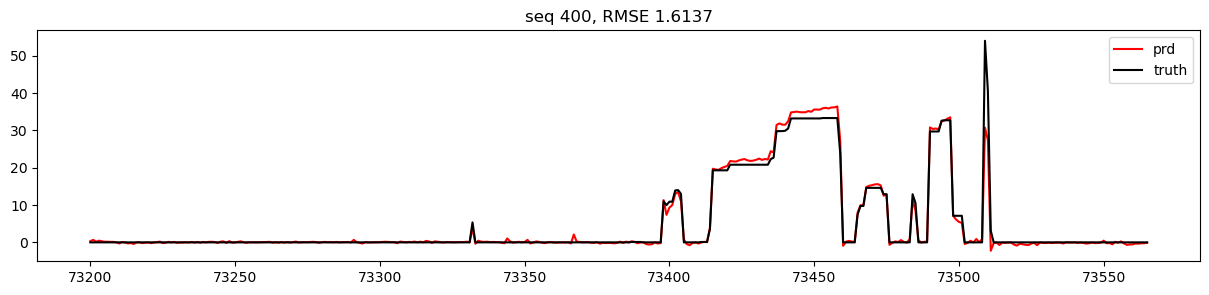

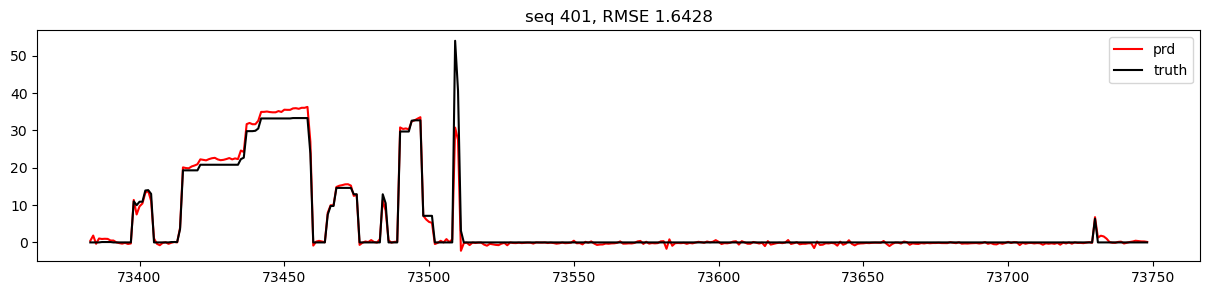

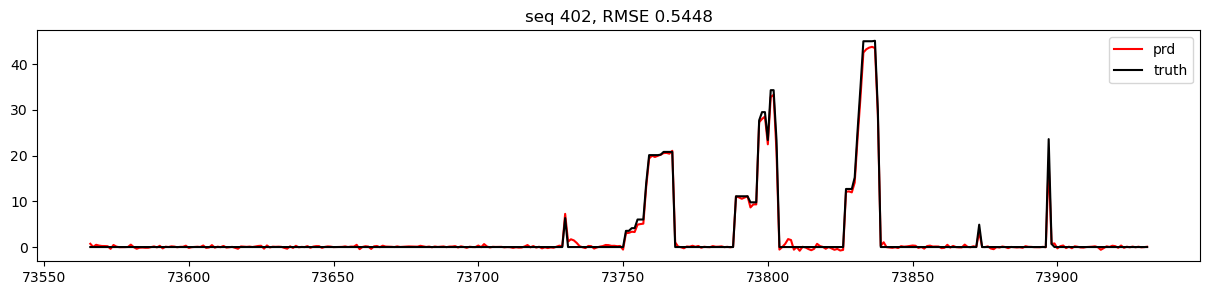

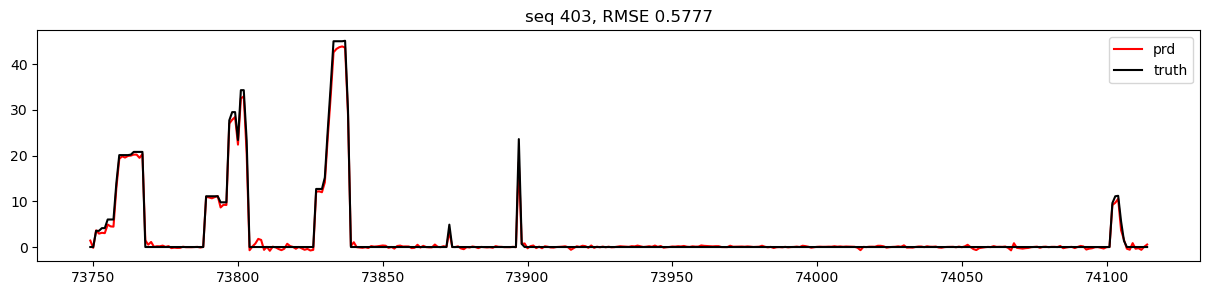

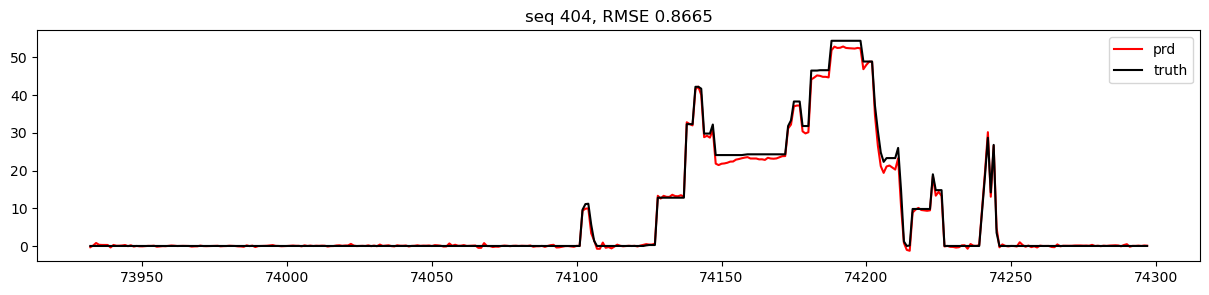

In [14]:
pred = pred_test_itrs[0]
for i in range(400,405):
    '''Static plot
    '''
    ig,ax = plt.subplots(1,1, figsize=(15,3))
    ax.plot(idx_arr[i],pred[i],c='r', label='prd')
    ax.plot(idx_arr[i],y_ori[i],c='black', label='truth')
    plt.title("seq {}, RMSE {:.4f}".format(i, np.sqrt(MSE(y_ori[i], pred[i], m_sp[i]))))
    plt.legend()
    plt.show()
    plt.close()

## Aggregated sequence Analysis

In [15]:
def get_pred_agg(pred, y, hiddens_list,idx_arr, keep='last_half'):
    '''
    Aggregate the prediction sequence. On testing.
    '''
    pred_agg = np.zeros(y.shape)
    hidden_list_agg = np.zeros((y.shape[0], hiddens_list.shape[-1]))
    
    if len(pred.shape) == 2:
        pred = np.expand_dims(pred, axis=2)

    assert(len(pred.shape) == 3)
    
    cnt = np.zeros(y.shape)
    cnt_hidden = np.zeros(hidden_list_agg.shape)
    
    # Keep the last half
    if keep == 'last_half':
        for i in range(len(pred)):
            if i == 0:
                cidx = idx_arr[i,:]
                pred_agg[cidx] = pred[i,:,:]
                hidden_list_agg[cidx] = hiddens_list[i,:,:]

            else:
                cidx = idx_arr[i][int(n_steps/2):]
                pred_agg[cidx] = pred_agg[cidx] + pred[i,int(n_steps/2):,:]
                hidden_list_agg[cidx] = hiddens_list[i,int(n_steps/2):,:]

            cnt[cidx] = cnt[cidx] + 1
            cnt_hidden[cidx] = cnt_hidden[cidx] + 1
    elif keep == 'first_half':
        for i in range(len(pred)):
            if i == len(pred)-1:
                cidx = idx_arr[i,:]
                pred_agg[cidx] = pred[i,:,:]
                hidden_list_agg[cidx] = hiddens_list[i,:,:]

            else:
                cidx = idx_arr[i][:int(n_steps/2)]
                pred_agg[cidx] = pred_agg[cidx] + pred[i,:int(n_steps/2),:]
                hidden_list_agg[cidx] = hiddens_list[i,:int(n_steps/2),:]

            cnt[cidx] = cnt[cidx] + 1
            cnt_hidden[cidx] = cnt_hidden[cidx] + 1

    assert(np.all(cnt>0))
    assert(np.all(cnt_hidden > 0))
    
    pred_agg = pred_agg*1.0/cnt
    hidden_list_agg = hidden_list_agg*1.0 / cnt_hidden
    return pred_agg, hidden_list_agg

In [16]:
def get_agg_pred_hiddens_iters(pred_itrs, hiddens_itrs, test_y, idx_arr,keep='last_half'):
    assert(len(pred_itrs) == len(hiddens_itrs))
    
    pred_agg_itrs = []
    hiddens_agg_itrs = []
    for i in range(len(pred_itrs)):
        pred_agg, hiddens_agg = get_pred_agg(pred_itrs[i], test_y, hiddens_itrs[i], idx_arr, keep)
        pred_agg_itrs.append(pred_agg)
        hiddens_agg_itrs.append(hiddens_agg)
    return pred_agg_itrs, hiddens_agg_itrs

def get_agg_rmses_itrs(pred_agg_itrs, y):
    rmses = np.zeros((max_iter, n_classes))
    for i in range(max_iter):
        for j in range(n_classes):
            rmses[i,j] = np.sqrt(MSE(pred_agg_itrs[i][:,j], y))
    return rmses

In [17]:
pred_test_agg_itrs, hiddens_test_agg_itrs = get_agg_pred_hiddens_iters(pred_test_itrs, hiddens_test_itrs, test_y, test_idx_arr)
rmses_test_itrs =  get_agg_rmses_itrs(pred_test_agg_itrs, np.squeeze(test_y))
print("Test RMSE Mean")
print(np.round(rmses_test_itrs,4))
print("Test RMSE Mean : {:.4f}".format(np.mean(rmses_test_itrs)))
print("Test RMSE STDV : {:.4f}".format(np.std(rmses_test_itrs)))

Test RMSE Mean
[[0.9984]
 [1.0986]
 [0.989 ]
 [0.9431]
 [0.9697]]
Test RMSE Mean : 0.9998
Test RMSE STDV : 0.0529


In [18]:
with open(exp_dir + "pred_test_agg_itrs.npy", 'wb') as f:
    np.save(f, pred_test_agg_itrs)
    
with open(exp_dir + "test_y.npy", 'wb') as f:
    np.save(f, test_y)

In [19]:
pred_test_agg_first_itrs, hiddens_test_agg_first_itrs = get_agg_pred_hiddens_iters(pred_test_itrs, hiddens_test_itrs, test_y, test_idx_arr,'first_half')
rmses_test_first_itrs =  get_agg_rmses_itrs(pred_test_agg_first_itrs, np.squeeze(test_y))
print("Test RMSE Mean")
print(np.round(rmses_test_first_itrs,4))
print("Test RMSE Mean : {:.4f}".format(np.mean(rmses_test_first_itrs)))
print("Test RMSE STDV : {:.4f}".format(np.std(rmses_test_first_itrs)))

Test RMSE Mean
[[1.1516]
 [1.2489]
 [1.1808]
 [1.1648]
 [1.1121]]
Test RMSE Mean : 1.1717
Test RMSE STDV : 0.0448


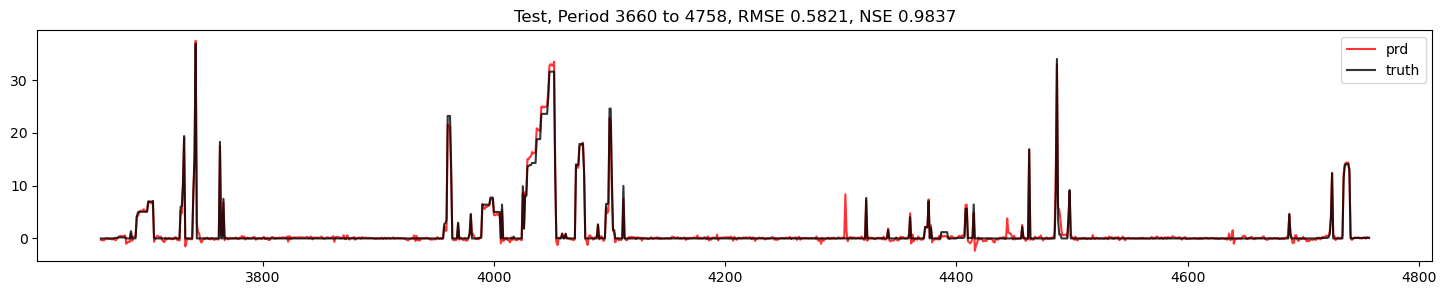

In [20]:
import seaborn as sns
pred_test_agg = pred_test_agg_itrs[0]
hidden_list_test_agg = hiddens_test_agg_itrs[0]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]
x = test_x[:,:]
hidden_agg = hidden_list_test_agg.copy()

low = 366*10
high = 366*13
period = np.arange(low,high)
pred_snippet = pred_agg[period]
y_snippet = y[period]
x_snippet = x[period]
ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(period,pred_snippet,c='r',alpha=0.8, label='prd')
ax.plot(period,y_snippet,c='black',alpha=0.8, label='truth')
plt.title("Test, Period {} to {}, RMSE {:.4f}, NSE {:.4f}".format(low,high, np.sqrt(MSE(pred_snippet, y_snippet)), get_NSE(y_snippet, pred_snippet)))
plt.legend()
plt.show()
plt.close()

# Analysis daily RMSE

In [21]:
dates = df['Date'].values
doys = np.array([datetime.strptime(cdate, '%Y-%m-%d').date().timetuple().tm_yday for cdate in dates])

pred_test_agg = pred_test_agg_itrs[0]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]

doy = doys[train_len+valid_len:]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]

In [22]:
df_res = pd.DataFrame(data = {'doy':doy, 'pred':pred_agg, 'obs':y})
daily_rmses = []
assert(min(df_res['doy'])==1 and max(df_res['doy'])==366)
for i in range(1, 367):
    chunk = df_res[df_res['doy'] == i]
    daily_rmses.append(np.sqrt(MSE(chunk['pred'], chunk['obs'])))

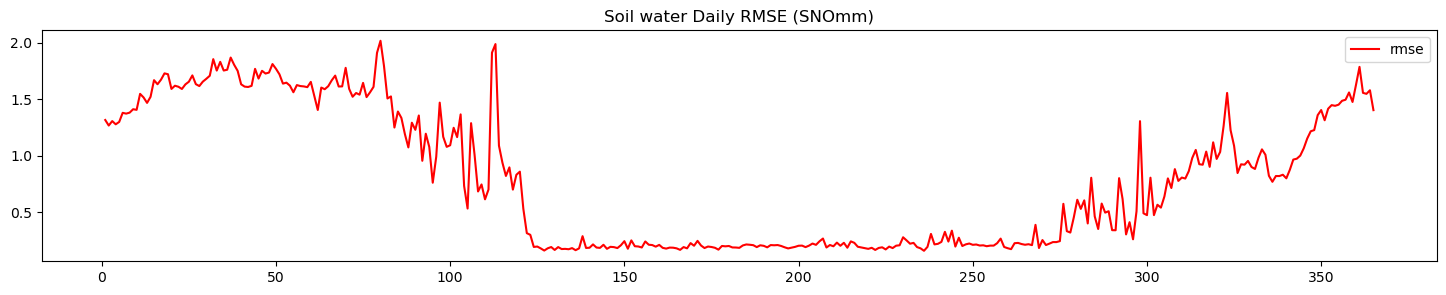

In [23]:
ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(np.arange(1,366),daily_rmses[:365],c='r', label='rmse')
plt.title("Soil water Daily RMSE ({})".format(output_var))
plt.legend()
plt.show()
plt.close()